# Simulate a Discrete-Time Dynamic System

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

from platform import python_version
print(f"Python: {python_version()}")
print(f"Jax: {jax.__version__}")

Python: 3.11.7
Jax: 0.4.23


## Example 1. First order auto-regressive model - AR(1)

In [2]:
def sys(yk, uk, params):
    a1 = params['a1']
    b0 = params['b0']
    return a1 * yk + b0 * uk

In [3]:
nT = 10
Ts = 1
t = Ts * jnp.arange(nT+1)
U = np.zeros((nT+1, 1), dtype='float32')
U[t >= 1, :] = 1.
U = jnp.array(U)

In [4]:
y0 = jnp.zeros(1, dtype='float32')
params = {
    'a1': 0.5,
    'b0': 0.5
}

In [5]:
# Simulate with Python for-loop
Y = []
yk = y0.copy()
for k in range(nT+1):
    Y.append(yk)
    uk = U[k, :]
    yk = sys(yk, uk, params)
Y = jnp.array(Y)

index = pd.Index(t, name='t')
sim_result = pd.concat(
    [pd.DataFrame(X, index=index) for X in [U, Y]],
    axis=1,
    keys=['U', 'Y']
)
sim_result.head()

,U,Y
,0,0
t,,
0,0.0,0.000
1,1.0,0.000
2,1.0,0.500
3,1.0,0.750
4,1.0,0.875


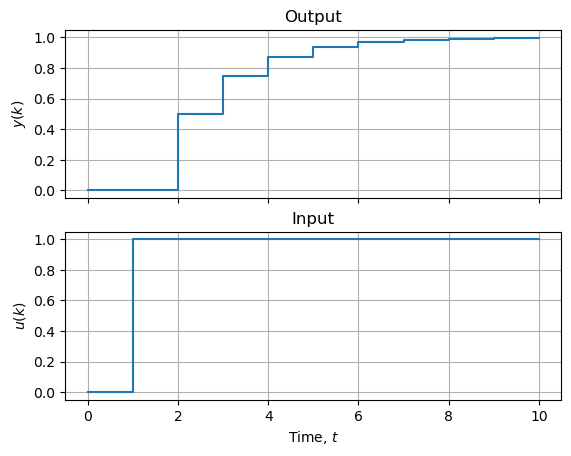

In [6]:
fig, axes = plt.subplots(2, 1, sharex=True)

ax = axes[0]
ax.step(t, Y, where='post')
ax.set_ylabel('$y(k)$')
ax.set_title('Output')
ax.grid()

ax = axes[1]
ax.step(t, U, where='post')
ax.set_ylabel('$u(k)$')
ax.set_xlabel('Time, $t$')
ax.set_title('Input')
ax.grid()

plt.show()

In [7]:
# Simulate using jax.scan
update = lambda yk, uk: (sys(yk, uk, params), yk)
_, Y = jax.lax.scan(update, y0, U)

sim_result_jax = pd.concat(
    [pd.DataFrame(X, index=index) for X in [U, Y]],
    axis=1,
    keys=['U', 'Y']
)
sim_result_jax.head()

,U,Y
,0,0
t,,
0,0.0,0.000
1,1.0,0.000
2,1.0,0.500
3,1.0,0.750
4,1.0,0.875


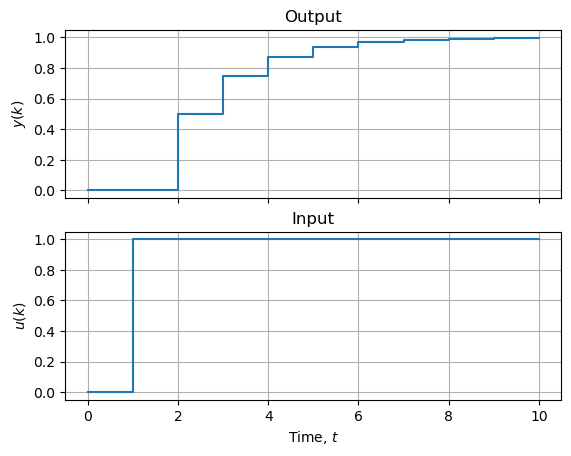

In [8]:
fig, axes = plt.subplots(2, 1, sharex=True)

ax = axes[0]
ax.step(t, Y, where='post')
ax.set_ylabel('$y(k)$')
ax.set_title('Output')
ax.grid()

ax = axes[1]
ax.step(t, U, where='post')
ax.set_ylabel('$u(k)$')
ax.set_xlabel('Time, $t$')
ax.set_title('Input')
ax.grid()

plt.show()

## Example 2. State-Space Model

In [9]:
# Linear state-space model
A = jnp.array([
    [ -6. ,  -0. ,   0. ,  -5. ],
    [ -0. ,  -6. ,   0.5,  -0. ],
    [  0. , -10. ,   0. ,  -0. ],
    [  1. ,   0. ,   0. ,  -0. ]
])
B = jnp.array([
    [10.,  0.],
    [ 0.,  1.],
    [ 0.,  0.],
    [ 0.,  0.]
])
C = jnp.array([
    [-0. , -0. , -0.5,  0.5],
    [ 1. , -0. , -1. ,  0.5]
])

def f(x, u):
    return A.dot(x) + B.dot(u)

def g(x, u):
    return C.dot(x)

def update(x, u):
    x = f(x, u)
    y = g(x, u)
    return x, y

x0 = jnp.zeros(4)

# Inputs
U = jnp.zeros((10, 2)).at[1:].set([1, 0]).at[5:].set([1, -1])

# Simulate
xN, Y = jax.lax.scan(update, x0, U)

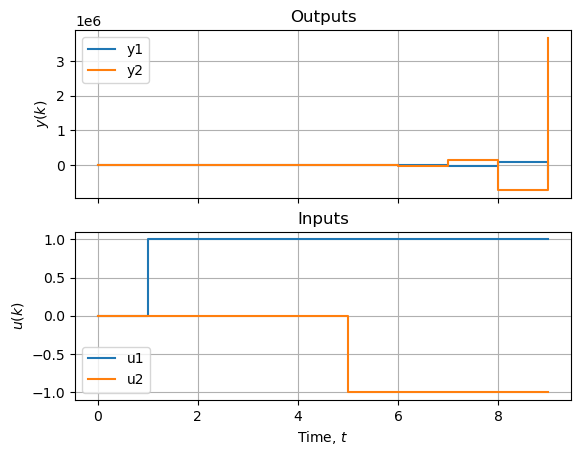

In [10]:
fig, axes = plt.subplots(2, 1, sharex=True)

t = np.arange(10).reshape(-1, 1)

ax = axes[0]
ax.step(t, Y, where='post', label=['y1', 'y2'])
ax.set_ylabel('$y(k)$')
ax.set_title('Outputs')
ax.grid()
ax.legend()

ax = axes[1]
ax.step(t, U, where='post', label=['u1', 'u2'])
ax.set_ylabel('$u(k)$')
ax.set_xlabel('Time, $t$')
ax.set_title('Inputs')
ax.grid()
ax.legend()

plt.show()

In [11]:
# This system is not stable!

## Example 3. Compare Python with Numpy and Jax

In [12]:
# Linear state-space model
A = np.array([
    [0.7925,       0],
    [     0,  0.8839]
])
B = np.array([
    [-0.1477, 0.1477],
    [ 0.1754, 0.1754]
])
C = np.array([
    [1., 0.],
    [0., 1.]
])

def f(x, u):
    return A.dot(x) + B.dot(u)

def g(x, u):
    return C.dot(x)

def update(x, u):
    x = f(x, u)
    y = g(x, u)
    return x, y

In [13]:
# Initial state
x0 = np.zeros(2)

# Inputs
nT = 99
U = np.zeros((nT+1, 2))
U[1:] = [1, 0]
U[21:] = [1, 0.5]
U[41:] = [-1, 0.5]
U[61:] = [-1, 1]

# Repeat 10 times
U = np.tile(U, (10, 1))
nT = U.shape[0] - 1
U.shape

(1000, 2)

In [14]:
%%time

# Simulate with Python for-loop
Y = []
xN = []
xk = x0
u0 = U[0, :]
y0 = g(x0, u0)
yk = y0.copy()
for k in range(nT+1):
    xN.append(xk)
    Y.append(yk)
    uk = U[k, :]
    xk, yk = update(xk, uk)
xN = np.array(xN)
Y = np.array(Y)

CPU times: user 5.89 ms, sys: 2.14 ms, total: 8.03 ms
Wall time: 6.65 ms


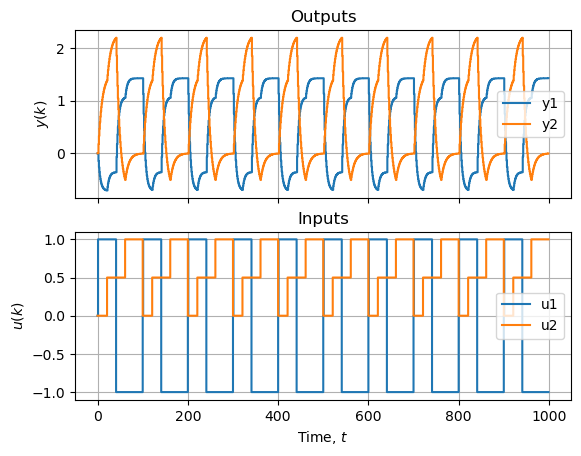

In [15]:
fig, axes = plt.subplots(2, 1, sharex=True)

t = np.arange(nT+1).reshape(-1, 1)

ax = axes[0]
ax.step(t, Y, where='post', label=['y1', 'y2'])
ax.set_ylabel('$y(k)$')
ax.set_title('Outputs')
ax.grid()
ax.legend()

ax = axes[1]
ax.step(t, U, where='post', label=['u1', 'u2'])
ax.set_ylabel('$u(k)$')
ax.set_xlabel('Time, $t$')
ax.set_title('Inputs')
ax.grid()
ax.legend()

plt.show()

In [16]:
# Jax version

# Linear state-space model
A = jnp.array(A)
B = jnp.array(B)
C = jnp.array(C)

def f(x, u):
    return A.dot(x) + B.dot(u)

def g(x, u):
    return C.dot(x)

def update(x, u):
    x = f(x, u)
    y = g(x, u)
    return x, y

In [17]:
%%time
# Simulate
xN, Y = jax.lax.scan(update, x0, U)

CPU times: user 62.3 ms, sys: 5.5 ms, total: 67.8 ms
Wall time: 136 ms


In [18]:
%%time
# Simulate
xN, Y = jax.lax.scan(update, x0, U)

CPU times: user 1.01 ms, sys: 638 µs, total: 1.65 ms
Wall time: 1.16 ms
